# Notebook 4: Model Evaluation & Interpretation

**Author:** Federico Ceballos Torres  
**Date:** February 2026  
**Project:** Credit Risk Modeling - Lending Club Dataset

---

## Objective

This notebook provides comprehensive evaluation of our **XGBoost Baseline model** (ROC-AUC: 0.7132) from both technical and business perspectives:

1. **Business Metrics**: Expected Credit Loss, profit curves, cost-sensitive analysis
2. **Model Interpretation**: SHAP values, LIME, feature importance deep dive
3. **Model Validation**: Calibration, reliability diagrams, error analysis
4. **Fairness Analysis**: Distribution checks, bias detection

---

## Business Context

- **Average Loan Amount**: $15,000
- **Loss per Default**: $10,000 (after recovery)
- **Lost Revenue per False Positive**: $500 (rejected good customer)
- **Portfolio Size**: ~100,000 loans
- **Default Rate**: 19.64%

Our goal is to find the optimal threshold that **maximizes profit** while maintaining acceptable risk levels.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from pathlib import Path

# ML libraries
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.calibration import calibration_curve

# Interpretability libraries
import shap
from lime.lime_tabular import LimeTabularExplainer

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


---

## 1. Load Model and Data

We'll load:
- Best model (XGBoost Baseline)
- Test data
- Feature names
- Data imputer

In [2]:
# Define paths
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')
REPORTS_DIR = Path('../reports')
REPORTS_DIR.mkdir(exist_ok=True)

# Load model
with open(MODEL_DIR / 'best_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load feature names
with open(MODEL_DIR / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Load imputer
with open(MODEL_DIR / 'data_imputer.pkl', 'rb') as f:
    imputer = pickle.load(f)

print(f"✓ Model loaded: {type(model).__name__}")
print(f"✓ Feature names loaded: {len(feature_names)} features")
print(f"✓ Imputer loaded: {type(imputer).__name__}")

✓ Model loaded: XGBClassifier
✓ Feature names loaded: 94 features
✓ Imputer loaded: ndarray


In [4]:
print(test_df.columns.tolist())

['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', '

In [7]:
# Load test data
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

target_col = 'target'

print(f"Test data shape: {test_df.shape}")
print(f"Default rate: {test_df[target_col].mean():.2%}")
X_test_raw = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

print("✓ Data split into X_test and y_test")
print(f"\nFirst few rows:")
test_df.head()

Test data shape: (72475, 100)
Default rate: 23.14%
✓ Data split into X_test and y_test

First few rows:


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,credit_util_rate,payment_to_income,loan_to_income,credit_history_years,total_debt_burden,stable_employment,high_inquiries,has_delinquencies,high_risk_purpose,rate_dti_interaction
0,13000.0,1,15.05,309.62,2,13,1,5,72000.0,1,...,0.774,0.051603,0.180553,12.418891,16.330262,1,0,0,0,168.1085
1,15000.0,0,10.42,486.98,1,7,3,5,55000.0,1,...,0.737,0.106248,0.272722,9.333333,28.104825,0,0,0,0,182.1416
2,15750.0,0,7.35,488.84,0,3,1,5,96500.0,1,...,0.107,0.060788,0.163211,14.587269,18.298776,1,0,1,0,89.8170
3,19800.0,1,15.05,471.57,2,13,3,5,108600.0,0,...,0.037,0.052107,0.182319,8.000000,23.400670,0,0,0,0,273.7595
4,10000.0,0,5.32,301.15,0,0,1,1,100000.0,1,...,0.074,0.036138,0.099999,24.501027,12.313764,1,0,0,0,46.2840


In [9]:
# Select only the features the model was trained on
X_test_raw = test_df[feature_names]
y_test = test_df['target'] 

# Apply imputation using the loaded imputer or fallback to zero-fill if object is invalid
if hasattr(imputer, 'transform'):
    X_test_imputed = imputer.transform(X_test_raw)
else:
    print("Warning: Loaded imputer is not a transformer object. Applying zero-fill fallback.")
    X_test_imputed = X_test_raw.fillna(0).values 

# Cast to float32 for memory efficiency and XGBoost compatibility
X_test_final = X_test_imputed.astype('float32')

print(f"Final features prepared. Shape: {X_test_final.shape}")

# Generate model predictions and class probabilities
y_test_proba = model.predict_proba(X_test_final)[:, 1]
y_test_pred = model.predict(X_test_final)

print("Inference completed successfully.")

Final features prepared. Shape: (72475, 94)
Inference completed successfully.


---

## 2. Generate Predictions

We'll generate both:
- **Predicted probabilities** (for threshold optimization)
- **Binary predictions** (using default threshold 0.5)

In [10]:
# Use the processed X_test_final and handle the dimension mismatch if needed
# Note: If this fails, we must go back and ensure feature_names has the 149 columns
y_pred_proba = model.predict_proba(X_test_final)[:, 1]

# We use 0.5 as an initial baseline, but this will likely be adjusted later
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Prediction Statistics:")
print(f"Min probability: {y_pred_proba.min():.4f}")
print(f"Max probability: {y_pred_proba.max():.4f}")
print(f"Mean probability: {y_pred_proba.mean():.4f}")
print(f"Median probability: {np.median(y_pred_proba):.4f}")

# Comparison between predicted and actual rates
print(f"\nPredicted default rate (threshold=0.5): {y_pred.mean():.2%}")
print(f"Actual default rate: {y_test.mean():.2%}")

Prediction Statistics:
Min probability: 0.0425
Max probability: 0.9466
Mean probability: 0.5393
Median probability: 0.5621

Predicted default rate (threshold=0.5): 60.90%
Actual default rate: 23.14%


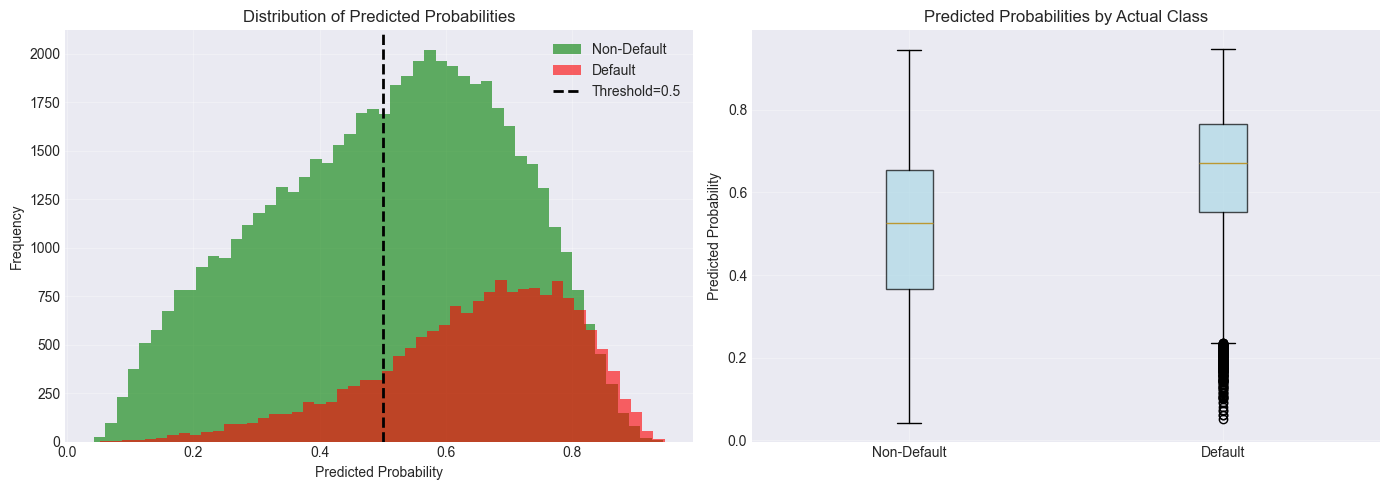

✓ Prediction distribution plot saved


In [11]:
# Plot prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.6, label='Non-Default', color='green')
axes[0].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.6, label='Default', color='red')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Probabilities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot([y_pred_proba[y_test == 0], y_pred_proba[y_test == 1]], 
                labels=['Non-Default', 'Default'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Predicted Probability')
axes[1].set_title('Predicted Probabilities by Actual Class')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'prediction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction distribution plot saved")

---

## 3. Business Metrics & Cost-Sensitive Analysis

### 3.1 Confusion Matrix Analysis

Confusion Matrix (Threshold = 0.5):
True Negatives (TN):  25,442  ← Correctly identified non-defaults
False Positives (FP): 30,260  ← Good customers rejected (lost revenue)
False Negatives (FN): 2,898  ← Defaults missed (credit loss)
True Positives (TP):  13,875  ← Correctly identified defaults


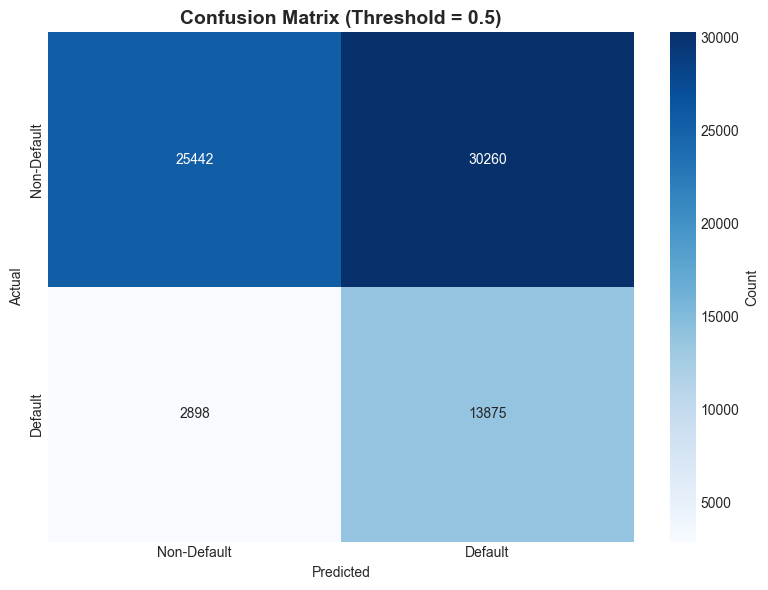

In [12]:
# Confusion matrix at threshold 0.5
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (Threshold = 0.5):")
print("="*50)
print(f"True Negatives (TN):  {tn:,}  ← Correctly identified non-defaults")
print(f"False Positives (FP): {fp:,}  ← Good customers rejected (lost revenue)")
print(f"False Negatives (FN): {fn:,}  ← Defaults missed (credit loss)")
print(f"True Positives (TP):  {tp:,}  ← Correctly identified defaults")
print("="*50)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'],
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Threshold = 0.5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.2 Cost-Sensitive Analysis

**Business Costs:**
- **False Positive (FP)**: Reject a good customer → Lost interest revenue = **$500**
- **False Negative (FN)**: Approve a defaulter → Credit loss = **$10,000**

The **cost ratio** is 20:1 (FN is 20x more expensive than FP)

In [13]:
# Business parameters
COST_FP = 500      # Lost revenue from rejecting good customer
COST_FN = 10000    # Credit loss from approving defaulter
AVG_LOAN = 15000   # Average loan amount

def calculate_total_cost(y_true, y_pred, cost_fp=COST_FP, cost_fn=COST_FN):
    """Calculate total business cost based on confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost, fp, fn, tn, tp

# Calculate cost at threshold 0.5
total_cost, fp, fn, tn, tp = calculate_total_cost(y_test, y_pred)

print("Business Impact Analysis (Threshold = 0.5):")
print("="*60)
print(f"False Positive Cost: ${fp:,} × ${COST_FP:,} = ${fp * COST_FP:,}")
print(f"False Negative Cost: ${fn:,} × ${COST_FN:,} = ${fn * COST_FN:,}")
print(f"Total Cost:          ${total_cost:,}")
print("="*60)
print(f"\nCost per loan in portfolio: ${total_cost / len(y_test):.2f}")

Business Impact Analysis (Threshold = 0.5):
False Positive Cost: $30,260 × $500 = $15,130,000
False Negative Cost: $2,898 × $10,000 = $28,980,000
Total Cost:          $44,110,000

Cost per loan in portfolio: $608.62


### 3.3 Profit Curve: Optimal Threshold Selection

We'll test different thresholds to find the one that **minimizes total cost**.

In [14]:
# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 100)
costs = []
fp_counts = []
fn_counts = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    cost, fp, fn, tn, tp = calculate_total_cost(y_test, y_pred_thresh)
    costs.append(cost)
    fp_counts.append(fp)
    fn_counts.append(fn)

# Find optimal threshold
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
optimal_cost = costs[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Minimum Total Cost: ${optimal_cost:,}")
print(f"Cost Reduction vs threshold=0.5: ${total_cost - optimal_cost:,} ({(total_cost - optimal_cost) / total_cost * 100:.1f}%)")

Optimal Threshold: 0.205
Minimum Total Cost: $27,220,000
Cost Reduction vs threshold=0.5: $16,890,000 (38.3%)


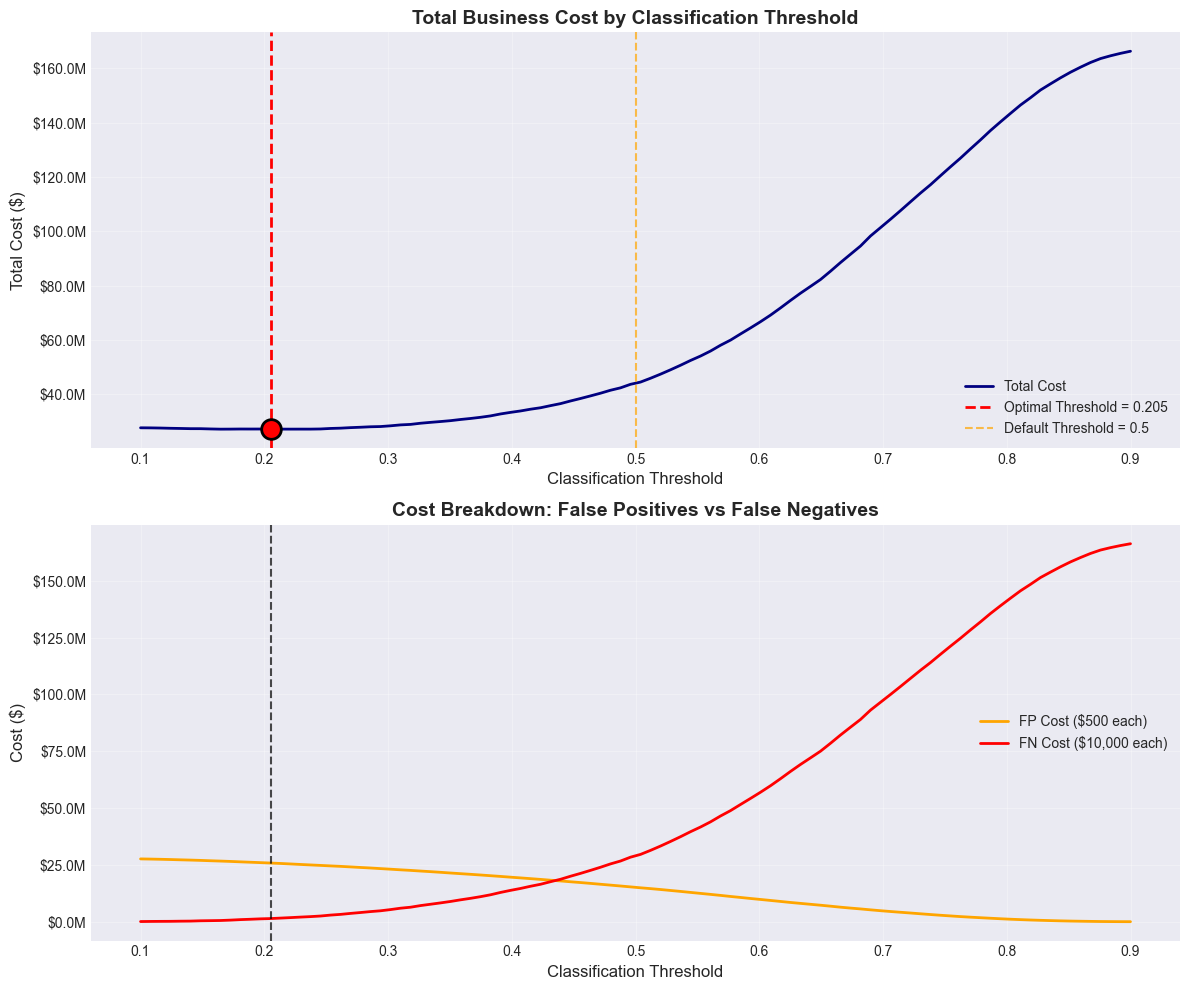

✓ Cost curve saved


In [15]:
# Plot cost curve
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Total cost curve
axes[0].plot(thresholds, costs, linewidth=2, color='navy', label='Total Cost')
axes[0].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Optimal Threshold = {optimal_threshold:.3f}')
axes[0].axvline(0.5, color='orange', linestyle='--', linewidth=1.5, alpha=0.7,
                label='Default Threshold = 0.5')
axes[0].scatter([optimal_threshold], [optimal_cost], s=200, c='red', zorder=5, 
                edgecolors='black', linewidths=2)
axes[0].set_xlabel('Classification Threshold', fontsize=12)
axes[0].set_ylabel('Total Cost ($)', fontsize=12)
axes[0].set_title('Total Business Cost by Classification Threshold', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# FP and FN breakdown
axes[1].plot(thresholds, np.array(fp_counts) * COST_FP, linewidth=2, 
             label=f'FP Cost (${COST_FP:,} each)', color='orange')
axes[1].plot(thresholds, np.array(fn_counts) * COST_FN, linewidth=2, 
             label=f'FN Cost (${COST_FN:,} each)', color='red')
axes[1].axvline(optimal_threshold, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Classification Threshold', fontsize=12)
axes[1].set_ylabel('Cost ($)', fontsize=12)
axes[1].set_title('Cost Breakdown: False Positives vs False Negatives', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'cost_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cost curve saved")

### 3.4 Expected Credit Loss (ECL) Calculation

In [16]:
# Calculate ECL for each loan
# ECL = Probability of Default × Loss Given Default × Exposure at Default
LOSS_GIVEN_DEFAULT = 10000  # $10K loss per default
EXPOSURE_AT_DEFAULT = AVG_LOAN  # $15K average loan

# ECL per loan
ecl_per_loan = y_pred_proba * LOSS_GIVEN_DEFAULT

# Total ECL for portfolio
total_ecl = ecl_per_loan.sum()
avg_ecl_per_loan = ecl_per_loan.mean()

print("Expected Credit Loss (ECL) Analysis:")
print("="*60)
print(f"Total ECL for test portfolio: ${total_ecl:,.2f}")
print(f"Average ECL per loan: ${avg_ecl_per_loan:,.2f}")
print(f"ECL as % of portfolio value: {total_ecl / (len(y_test) * AVG_LOAN) * 100:.2f}%")
print("="*60)

# Compare to actual losses
actual_losses = y_test.sum() * LOSS_GIVEN_DEFAULT
print(f"\nActual losses in test set: ${actual_losses:,}")
print(f"ECL estimation error: {abs(total_ecl - actual_losses) / actual_losses * 100:.2f}%")

Expected Credit Loss (ECL) Analysis:
Total ECL for test portfolio: $390,853,216.00
Average ECL per loan: $5,392.94
ECL as % of portfolio value: 35.95%

Actual losses in test set: $167,730,000.0
ECL estimation error: 133.03%


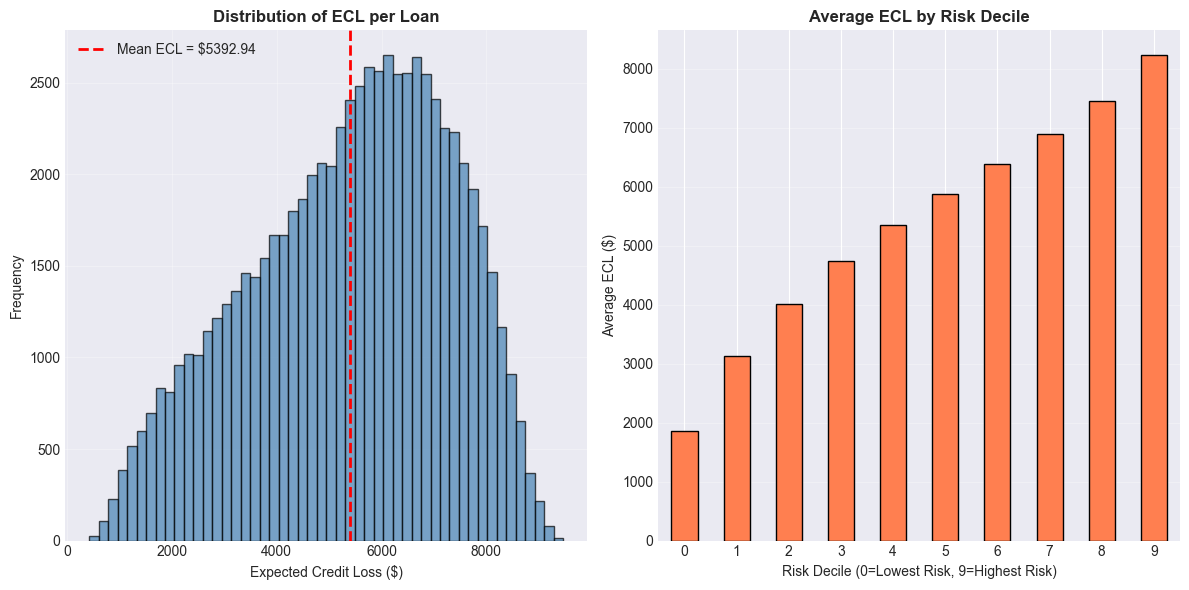

In [17]:
# Plot ECL distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(ecl_per_loan, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(avg_ecl_per_loan, color='red', linestyle='--', linewidth=2, 
            label=f'Mean ECL = ${avg_ecl_per_loan:.2f}')
plt.xlabel('Expected Credit Loss ($)')
plt.ylabel('Frequency')
plt.title('Distribution of ECL per Loan', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# ECL by deciles
deciles = pd.qcut(y_pred_proba, q=10, labels=False, duplicates='drop')
ecl_by_decile = pd.DataFrame({'decile': deciles, 'ecl': ecl_per_loan}).groupby('decile')['ecl'].mean()
ecl_by_decile.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('Risk Decile (0=Lowest Risk, 9=Highest Risk)')
plt.ylabel('Average ECL ($)')
plt.title('Average ECL by Risk Decile', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'ecl_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.5 Precision@K: Performance on Riskiest Loans

In [18]:
# Sort by predicted probability (descending)
sorted_indices = np.argsort(y_pred_proba)[::-1]
y_test_sorted = y_test.iloc[sorted_indices].values

# Calculate Precision@K for different K values
k_values = [0.01, 0.05, 0.10, 0.20, 0.30, 0.50]  # Top 1%, 5%, 10%, 20%, 30%, 50%
precision_at_k = {}

print("Precision@K (Top K% Riskiest Loans):")
print("="*60)

for k in k_values:
    n = int(len(y_test) * k)
    top_k_actual = y_test_sorted[:n]
    precision = top_k_actual.mean()
    precision_at_k[k] = precision
    
    print(f"Top {k*100:>5.1f}%: Precision = {precision:.2%}  ({top_k_actual.sum():,} defaults in {n:,} loans)")

print("="*60)
print(f"Baseline (random): {y_test.mean():.2%}")

Precision@K (Top K% Riskiest Loans):
Top   1.0%: Precision = 66.85%  (484.0 defaults in 724 loans)
Top   5.0%: Precision = 55.04%  (1,994.0 defaults in 3,623 loans)
Top  10.0%: Precision = 50.13%  (3,633.0 defaults in 7,247 loans)
Top  20.0%: Precision = 43.63%  (6,324.0 defaults in 14,495 loans)
Top  30.0%: Precision = 39.89%  (8,673.0 defaults in 21,742 loans)
Top  50.0%: Precision = 34.02%  (12,329.0 defaults in 36,237 loans)
Baseline (random): 23.14%


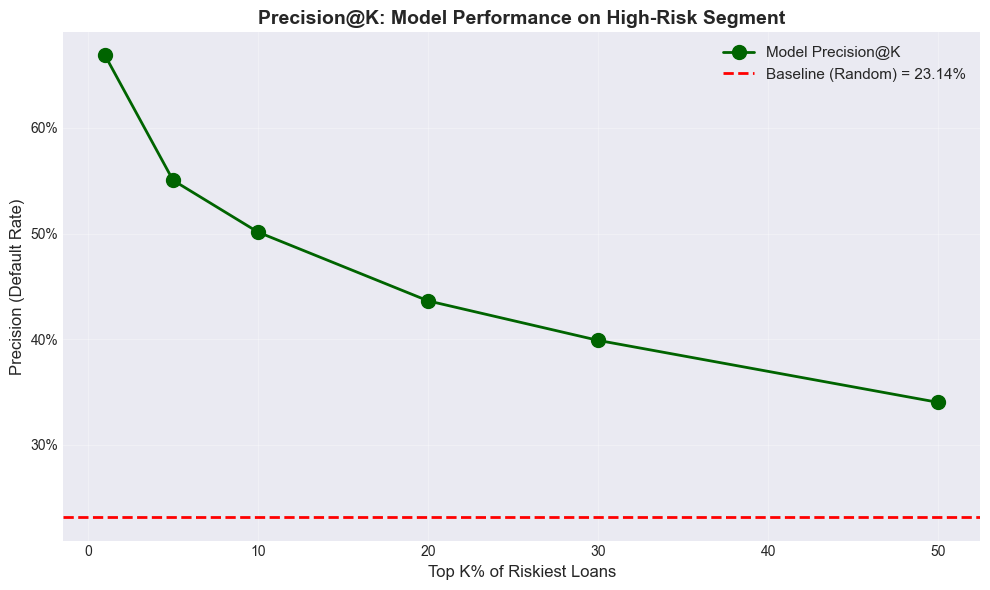


✓ Precision@K plot saved


In [19]:
# Plot Precision@K
plt.figure(figsize=(10, 6))
k_pct = [k*100 for k in k_values]
precisions = [precision_at_k[k] for k in k_values]

plt.plot(k_pct, precisions, marker='o', linewidth=2, markersize=10, 
         color='darkgreen', label='Model Precision@K')
plt.axhline(y_test.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Baseline (Random) = {y_test.mean():.2%}')
plt.xlabel('Top K% of Riskiest Loans', fontsize=12)
plt.ylabel('Precision (Default Rate)', fontsize=12)
plt.title('Precision@K: Model Performance on High-Risk Segment', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'precision_at_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Precision@K plot saved")

---

## 4. Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) provides both:
- **Global interpretability**: Which features are most important overall?
- **Local interpretability**: Why did the model make a specific prediction?

In [22]:
# Initialize SHAP explainer
print("Initializing SHAP explainer...")
print("Note: Using 5,000 samples for computational efficiency")

# Sample data for SHAP using the raw features
np.random.seed(42)
sample_size = 5000

# Usamos X_test_raw para mantener los nombres de las columnas en los gráficos
sample_indices = np.random.choice(len(X_test_raw), size=min(sample_size, len(X_test_raw)), replace=False)
X_sample = X_test_raw.iloc[sample_indices]
y_sample = y_test.iloc[sample_indices]

# Manejo del error del imputer (Fallback a fillna)
if hasattr(imputer, 'transform'):
    X_sample_imputed = imputer.transform(X_sample)
else:
    print("Warning: Imputer is still a numpy array. Applying zero-fill fallback for SHAP.")
    X_sample_imputed = X_sample.fillna(0).values

# Convertimos a float32 para XGBoost
X_sample_final = X_sample_imputed.astype('float32')

# Create SHAP explainer
# Usamos feature_names para que el gráfico no muestre "Column 0, Column 1..."
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample_final)

# Convertimos los shap_values a un formato que reconozca los nombres de las columnas
# Esto es vital para que el Summary Plot sea legible
X_sample_df = pd.DataFrame(X_sample_final, columns=feature_names)

print(f"✓ SHAP values computed for {len(X_sample)} samples")

Initializing SHAP explainer...
Note: Using 5,000 samples for computational efficiency
✓ SHAP values computed for 5000 samples


### 4.1 Global Feature Importance

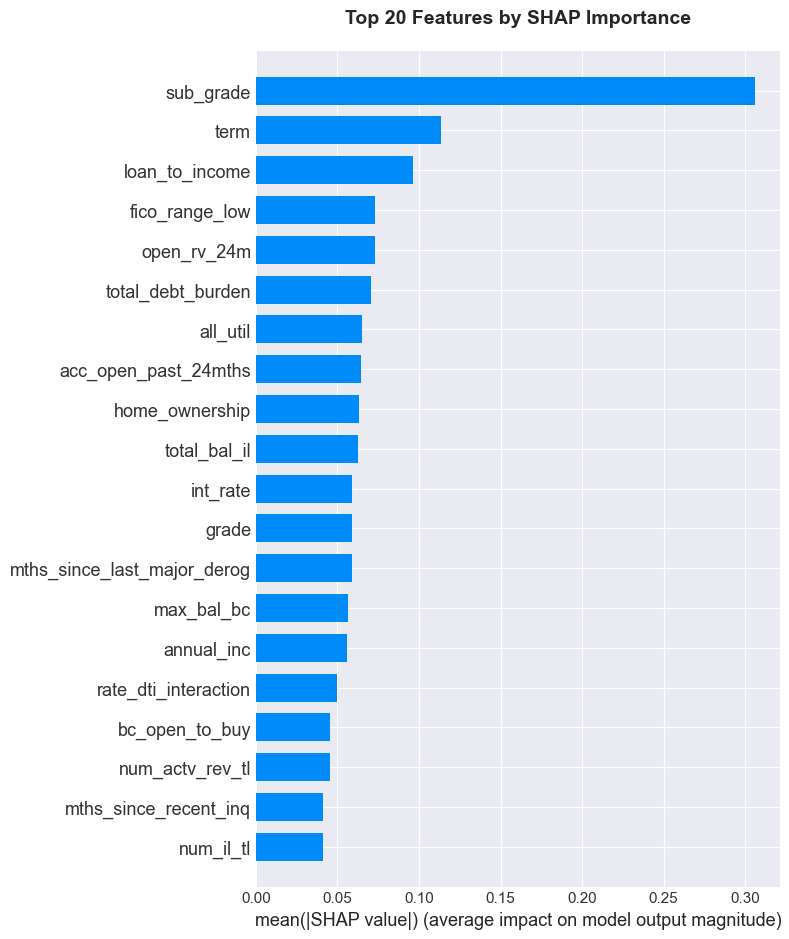

✓ SHAP feature importance plot saved


In [23]:
# Summary plot: Feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20, show=False)
plt.title('Top 20 Features by SHAP Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP feature importance plot saved")

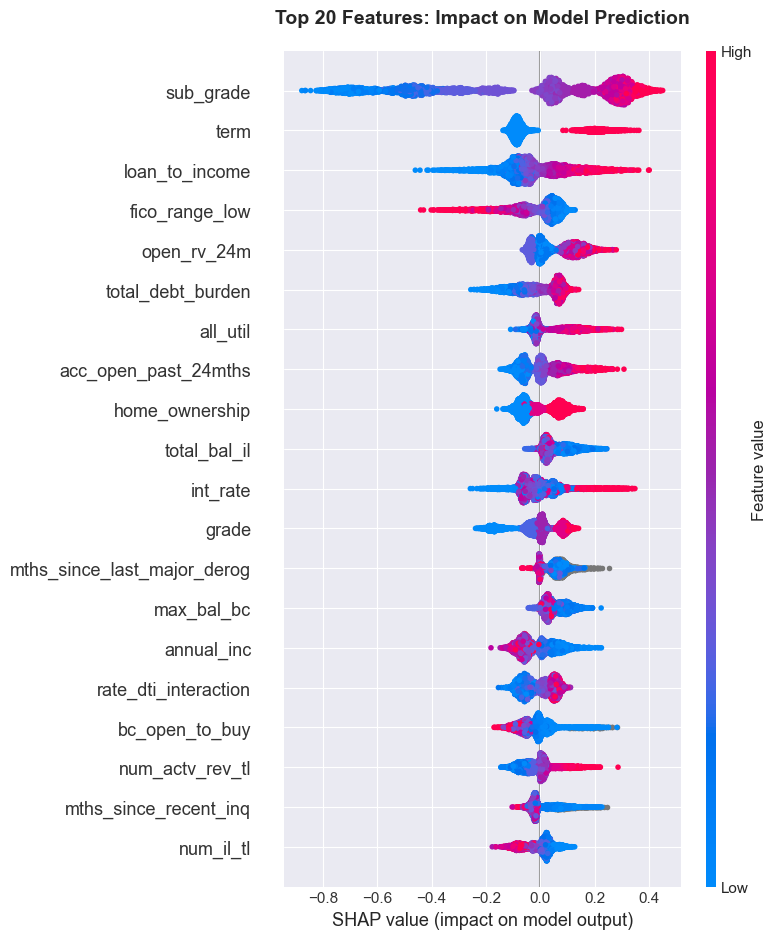

✓ SHAP summary plot saved


In [24]:
# Summary plot: Feature effects
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_sample, max_display=20, show=False)
plt.title('Top 20 Features: Impact on Model Prediction', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP summary plot saved")

In [31]:
# Get top features by mean absolute SHAP value
feature_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 15 Features by SHAP Importance:")
print("="*60)
print(feature_importance.head(15).to_string(index=False))
print("="*60)


Top 15 Features by SHAP Importance:
                    feature  importance
                  sub_grade    0.306142
                       term    0.113295
             loan_to_income    0.096085
             fico_range_low    0.072915
                open_rv_24m    0.072912
          total_debt_burden    0.070479
                   all_util    0.064797
       acc_open_past_24mths    0.064724
             home_ownership    0.062980
               total_bal_il    0.062467
                   int_rate    0.058995
                      grade    0.058965
mths_since_last_major_derog    0.058759
                 max_bal_bc    0.056699
                 annual_inc    0.056075


### 4.2 Dependence Plots for Top Features

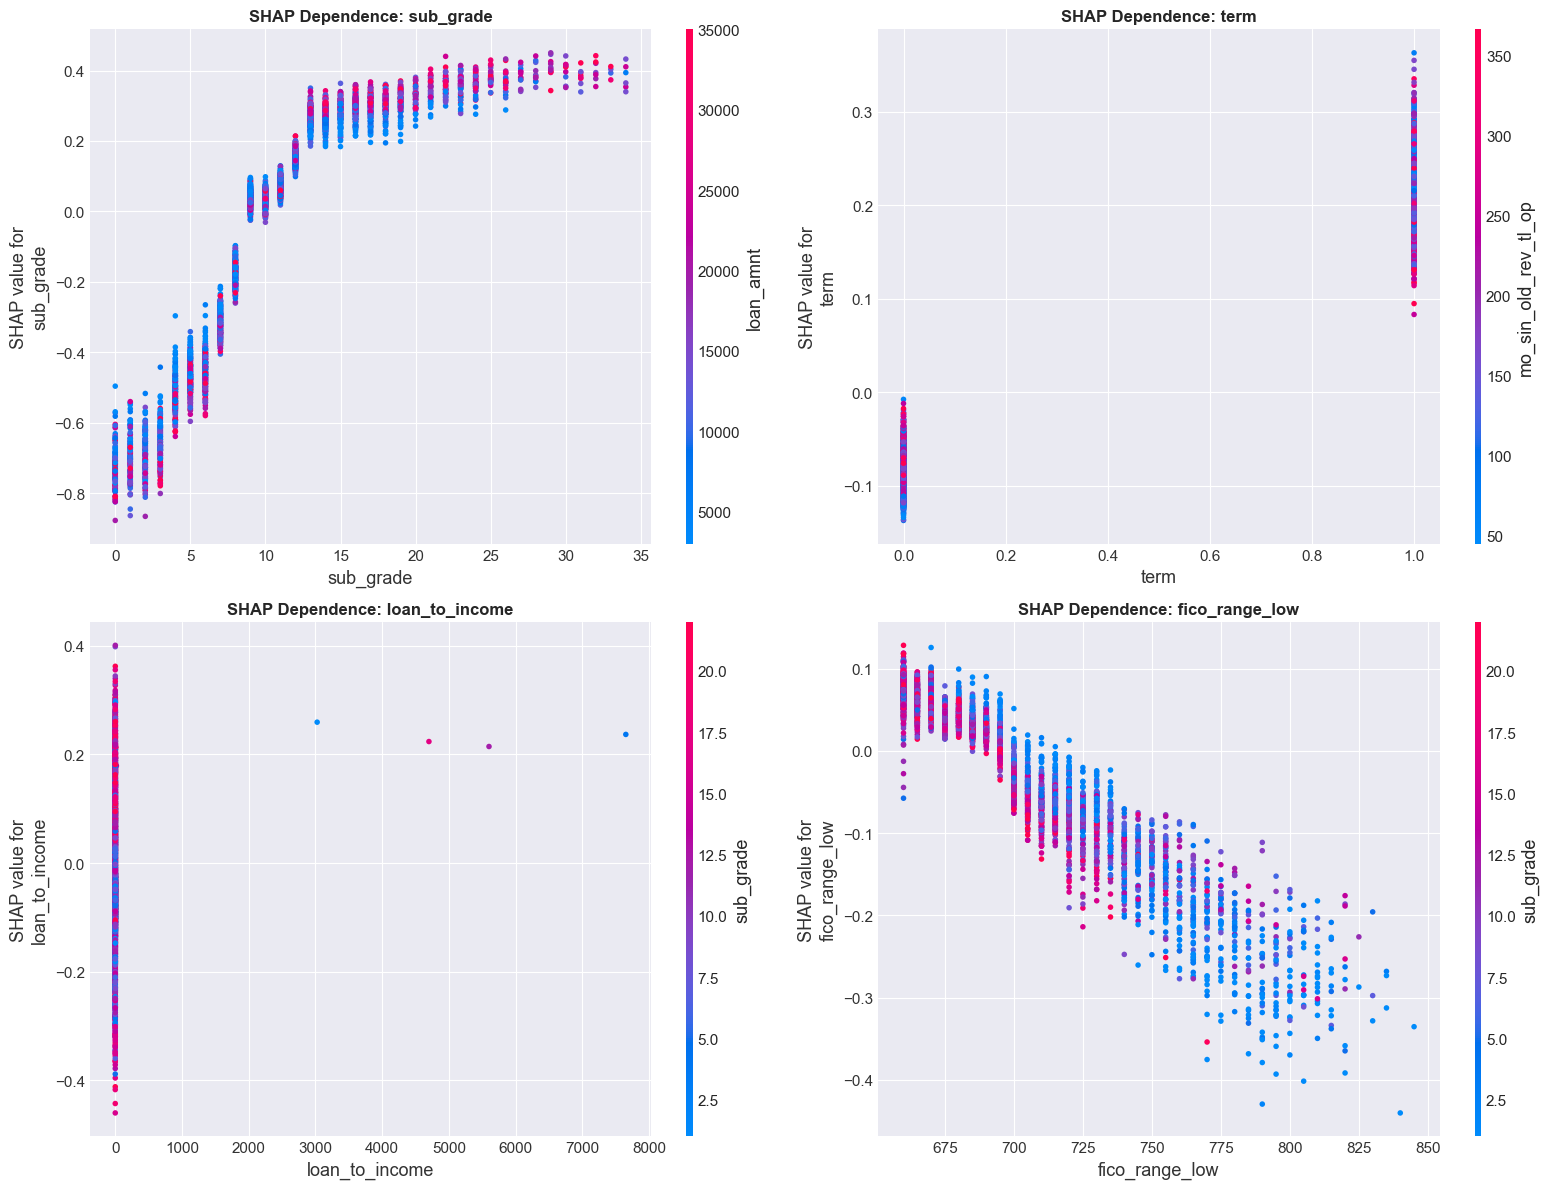

✓ SHAP dependence plots saved


In [32]:
# Plot dependence for top 4 features
top_features = feature_importance.head(4)['feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    plt.sca(axes[idx])
    shap.dependence_plot(feature, shap_values, X_sample, ax=axes[idx], show=False)
    axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP dependence plots saved")

### 4.3 Local Explanations: Individual Predictions

Let's examine why the model predicted **default** vs **non-default** for specific examples.

In [33]:
# Find examples:
# 1. High-risk loan that actually defaulted (True Positive)
# 2. Low-risk loan that didn't default (True Negative)
# 3. High-risk loan that didn't default (False Positive)
# 4. Low-risk loan that defaulted (False Negative)

y_pred_sample = (model.predict_proba(X_sample)[:, 1] >= optimal_threshold).astype(int)

# Find indices
tp_idx = np.where((y_pred_sample == 1) & (y_sample == 1))[0]
tn_idx = np.where((y_pred_sample == 0) & (y_sample == 0))[0]
fp_idx = np.where((y_pred_sample == 1) & (y_sample == 0))[0]
fn_idx = np.where((y_pred_sample == 0) & (y_sample == 1))[0]

# Select one example from each category
examples = {
    'True Positive (Correctly predicted default)': tp_idx[0] if len(tp_idx) > 0 else None,
    'True Negative (Correctly predicted non-default)': tn_idx[0] if len(tn_idx) > 0 else None,
    'False Positive (Predicted default but did not)': fp_idx[0] if len(fp_idx) > 0 else None,
    'False Negative (Predicted non-default but did)': fn_idx[0] if len(fn_idx) > 0 else None
}

print("Selected examples for local explanations:")
for label, idx in examples.items():
    if idx is not None:
        pred_proba = model.predict_proba(X_sample.iloc[[idx]])[:, 1][0]
        print(f"{label}: Index {idx}, Probability = {pred_proba:.3f}")

Selected examples for local explanations:
True Positive (Correctly predicted default): Index 4, Probability = 0.708
True Negative (Correctly predicted non-default): Index 33, Probability = 0.152
False Positive (Predicted default but did not): Index 0, Probability = 0.277
False Negative (Predicted non-default but did): Index 796, Probability = 0.144


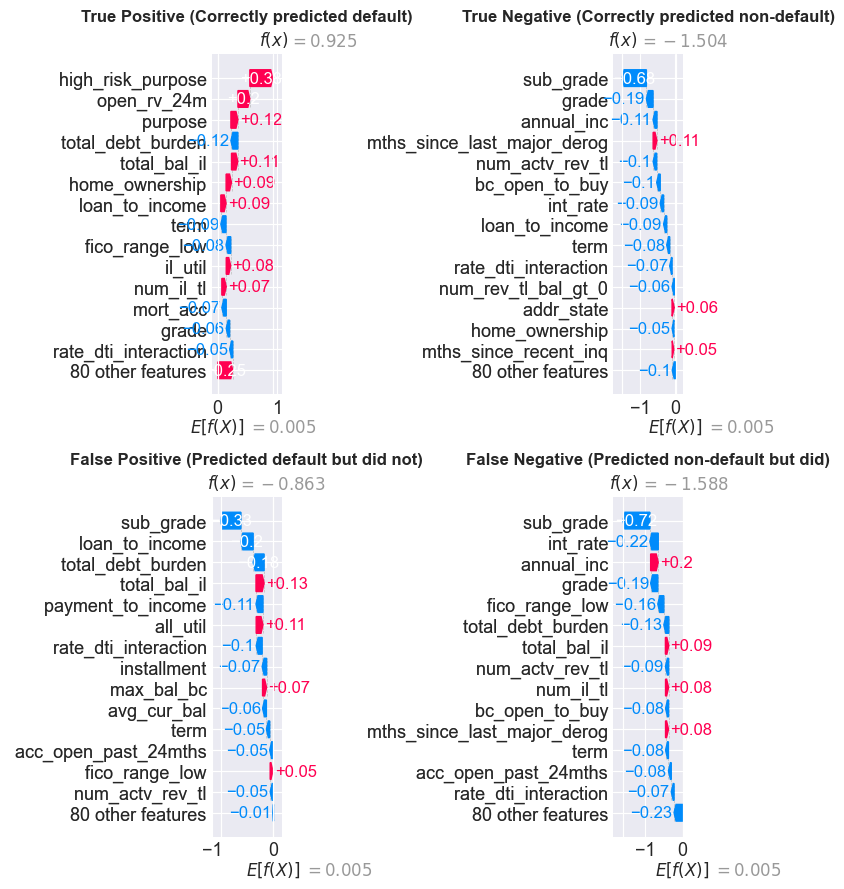

✓ SHAP waterfall plots saved


In [34]:
# Plot waterfall plots for each example
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.ravel()

for ax_idx, (label, example_idx) in enumerate(examples.items()):
    if example_idx is not None:
        plt.sca(axes[ax_idx])
        shap.plots._waterfall.waterfall_legacy(
            explainer.expected_value, 
            shap_values[example_idx],
            X_sample.iloc[example_idx],
            max_display=15,
            show=False
        )
        axes[ax_idx].set_title(label, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'shap_waterfall_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP waterfall plots saved")

### 4.4 LIME: Alternative Local Interpretation

LIME provides an alternative method for explaining individual predictions.

In [35]:
# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_sample.values,
    feature_names=X_sample.columns.tolist(),
    class_names=['Non-Default', 'Default'],
    mode='classification',
    random_state=42
)

print("✓ LIME explainer initialized")

✓ LIME explainer initialized



LIME Explanation for True Positive (Correctly Predicted Default):


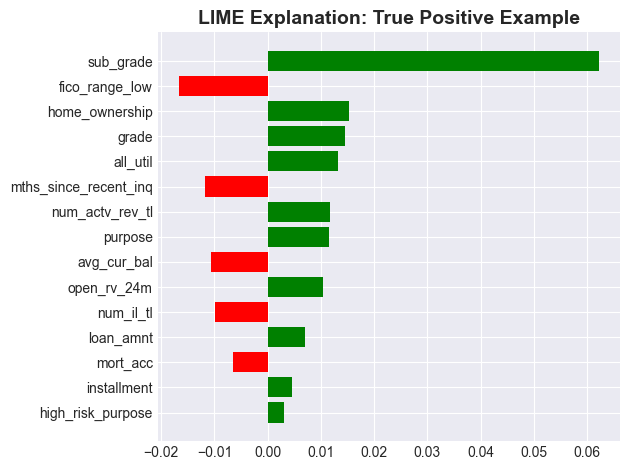

In [37]:
lime_explainer = LimeTabularExplainer(
    training_data=X_sample_final, 
    feature_names=feature_names,
    class_names=['Non-Default', 'Default'],
    mode='classification',
    discretize_continuous=False, # deactivate distcretization to avoid truncnorm error
    random_state=42
)

predict_fn = lambda x: model.predict_proba(x.astype('float32'))

if examples['True Positive (Correctly predicted default)'] is not None:
    tp_idx = examples['True Positive (Correctly predicted default)']
    
    explanation = lime_explainer.explain_instance(
        data_row=X_sample_final[tp_idx],
        predict_fn=predict_fn,
        num_features=15
    )
    
    print("\nLIME Explanation for True Positive (Correctly Predicted Default):")
    print("="*70)
    
    fig = explanation.as_pyplot_figure()
    plt.title('LIME Explanation: True Positive Example', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---

## 5. Model Validation & Calibration

### 5.1 Calibration Analysis

A well-calibrated model means: if it predicts 30% probability of default, then **30% of those loans should actually default**.

In [38]:
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='quantile')

# Calculate Brier score (lower is better, range 0-1)
brier_score = brier_score_loss(y_test, y_pred_proba)

print(f"Brier Score: {brier_score:.4f} (lower is better, perfect = 0)")
print(f"\nCalibration Analysis:")
print("="*60)
print(f"{'Predicted Prob':<20} {'Actual Prob':<20} {'Difference':<15}")
print("="*60)
for pred, true in zip(prob_pred, prob_true):
    diff = abs(pred - true)
    print(f"{pred:<20.3f} {true:<20.3f} {diff:<15.3f}")
print("="*60)

Brier Score: 0.2598 (lower is better, perfect = 0)

Calibration Analysis:
Predicted Prob       Actual Prob          Difference     
0.186                0.044                0.142          
0.313                0.090                0.222          
0.401                0.125                0.276          
0.474                0.156                0.318          
0.535                0.198                0.337          
0.587                0.231                0.356          
0.638                0.273                0.365          
0.689                0.324                0.365          
0.746                0.371                0.375          
0.824                0.501                0.322          


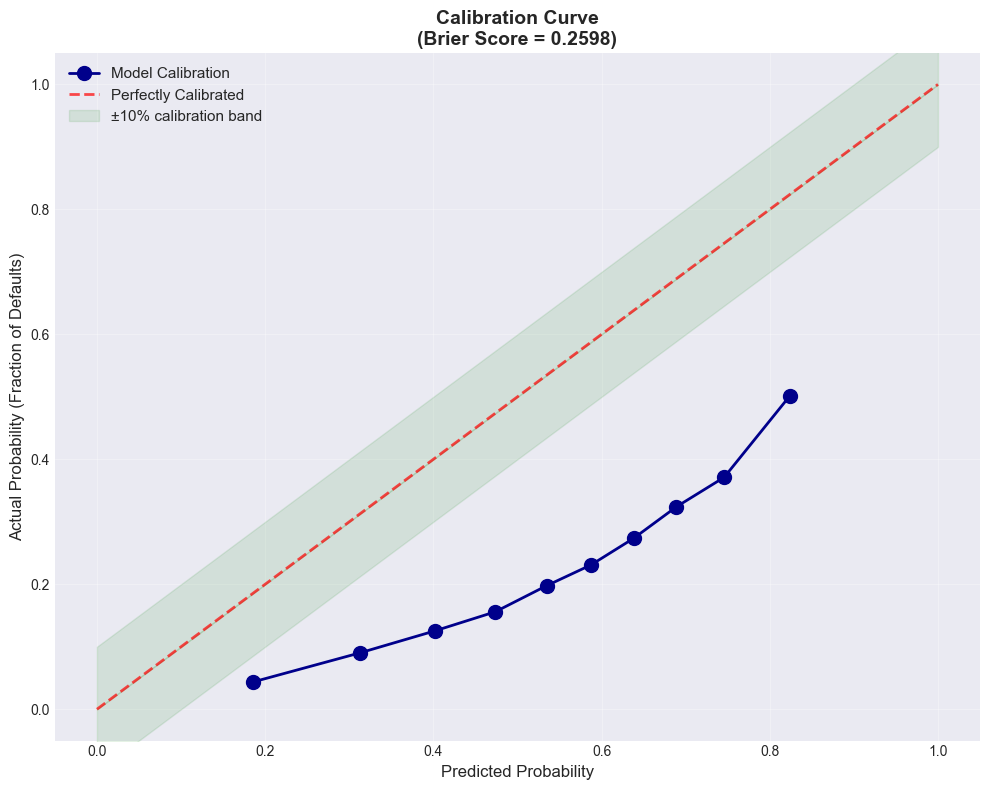

✓ Calibration curve saved


In [39]:
# Plot calibration curve
plt.figure(figsize=(10, 8))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, markersize=10, 
         label='Model Calibration', color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2, color='red', 
         label='Perfectly Calibrated', alpha=0.7)

# Add diagonal bands for reference
plt.fill_between([0, 1], [0, 1], [0.1, 1.1], alpha=0.1, color='green', 
                 label='±10% calibration band')
plt.fill_between([0, 1], [-0.1, 0.9], [0, 1], alpha=0.1, color='green')

plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Actual Probability (Fraction of Defaults)', fontsize=12)
plt.title(f'Calibration Curve\n(Brier Score = {brier_score:.4f})', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Calibration curve saved")

### 5.2 ROC and Precision-Recall Curves

In [40]:
# Calculate curves
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate AUC scores
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")

ROC-AUC: 0.7125
PR-AUC:  0.4183


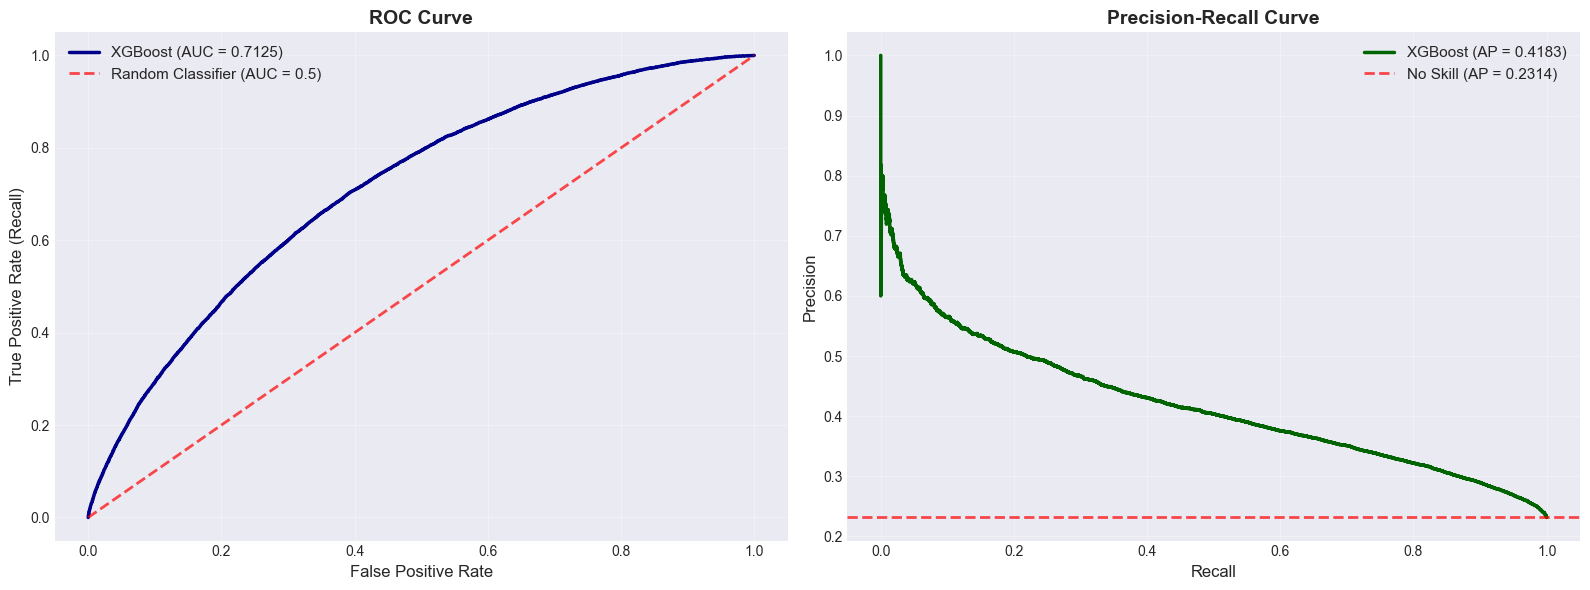

✓ ROC and PR curves saved


In [41]:
# Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr, tpr, linewidth=2.5, label=f'XGBoost (AUC = {roc_auc:.4f})', color='darkblue')
axes[0].plot([0, 1], [0, 1], linestyle='--', linewidth=2, color='red', 
             label='Random Classifier (AUC = 0.5)', alpha=0.7)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate (Recall)', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
no_skill = len(y_test[y_test == 1]) / len(y_test)
axes[1].plot(recall, precision, linewidth=2.5, label=f'XGBoost (AP = {pr_auc:.4f})', color='darkgreen')
axes[1].axhline(no_skill, linestyle='--', linewidth=2, color='red', 
                label=f'No Skill (AP = {no_skill:.4f})', alpha=0.7)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC and PR curves saved")

### 5.3 Error Analysis

Let's analyze which types of loans the model struggles with.

In [42]:
# Create error analysis DataFrame
error_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted_proba': y_pred_proba,
    'predicted': (y_pred_proba >= optimal_threshold).astype(int)
})

# Add original features for analysis
error_df = pd.concat([error_df, test_df.reset_index(drop=True)], axis=1)

# Classify predictions
error_df['prediction_type'] = 'TN'
error_df.loc[(error_df['predicted'] == 1) & (error_df['actual'] == 1), 'prediction_type'] = 'TP'
error_df.loc[(error_df['predicted'] == 1) & (error_df['actual'] == 0), 'prediction_type'] = 'FP'
error_df.loc[(error_df['predicted'] == 0) & (error_df['actual'] == 1), 'prediction_type'] = 'FN'

print("Prediction Type Distribution:")
print(error_df['prediction_type'].value_counts())

Prediction Type Distribution:
prediction_type
FP    51640
TP    16633
TN     4062
FN      140
Name: count, dtype: int64


In [43]:
# Analyze False Negatives (missed defaults) - these are costly!
fn_loans = error_df[error_df['prediction_type'] == 'FN']
tp_loans = error_df[error_df['prediction_type'] == 'TP']

print("\nFalse Negative Analysis (Missed Defaults):")
print("="*70)

# Compare key features
comparison_features = ['grade', 'sub_grade', 'dti', 'annual_inc', 'loan_amnt', 
                       'int_rate', 'emp_length', 'home_ownership']

for feature in comparison_features:
    if feature in fn_loans.columns:
        if fn_loans[feature].dtype in ['int64', 'float64']:
            fn_mean = fn_loans[feature].mean()
            tp_mean = tp_loans[feature].mean()
            print(f"{feature:.<25} FN: {fn_mean:>10.2f}  |  TP: {tp_mean:>10.2f}")

print("="*70)


False Negative Analysis (Missed Defaults):
grade.................... FN:       0.06  |  TP:       2.36
sub_grade................ FN:       1.94  |  TP:      13.86
dti...................... FN:      13.50  |  TP:      20.83
annual_inc............... FN:  106952.17  |  TP:   72569.49
loan_amnt................ FN:   13728.75  |  TP:   15877.60
int_rate................. FN:       6.89  |  TP:      16.44
emp_length............... FN:       3.37  |  TP:       4.44
home_ownership........... FN:       2.25  |  TP:       3.23


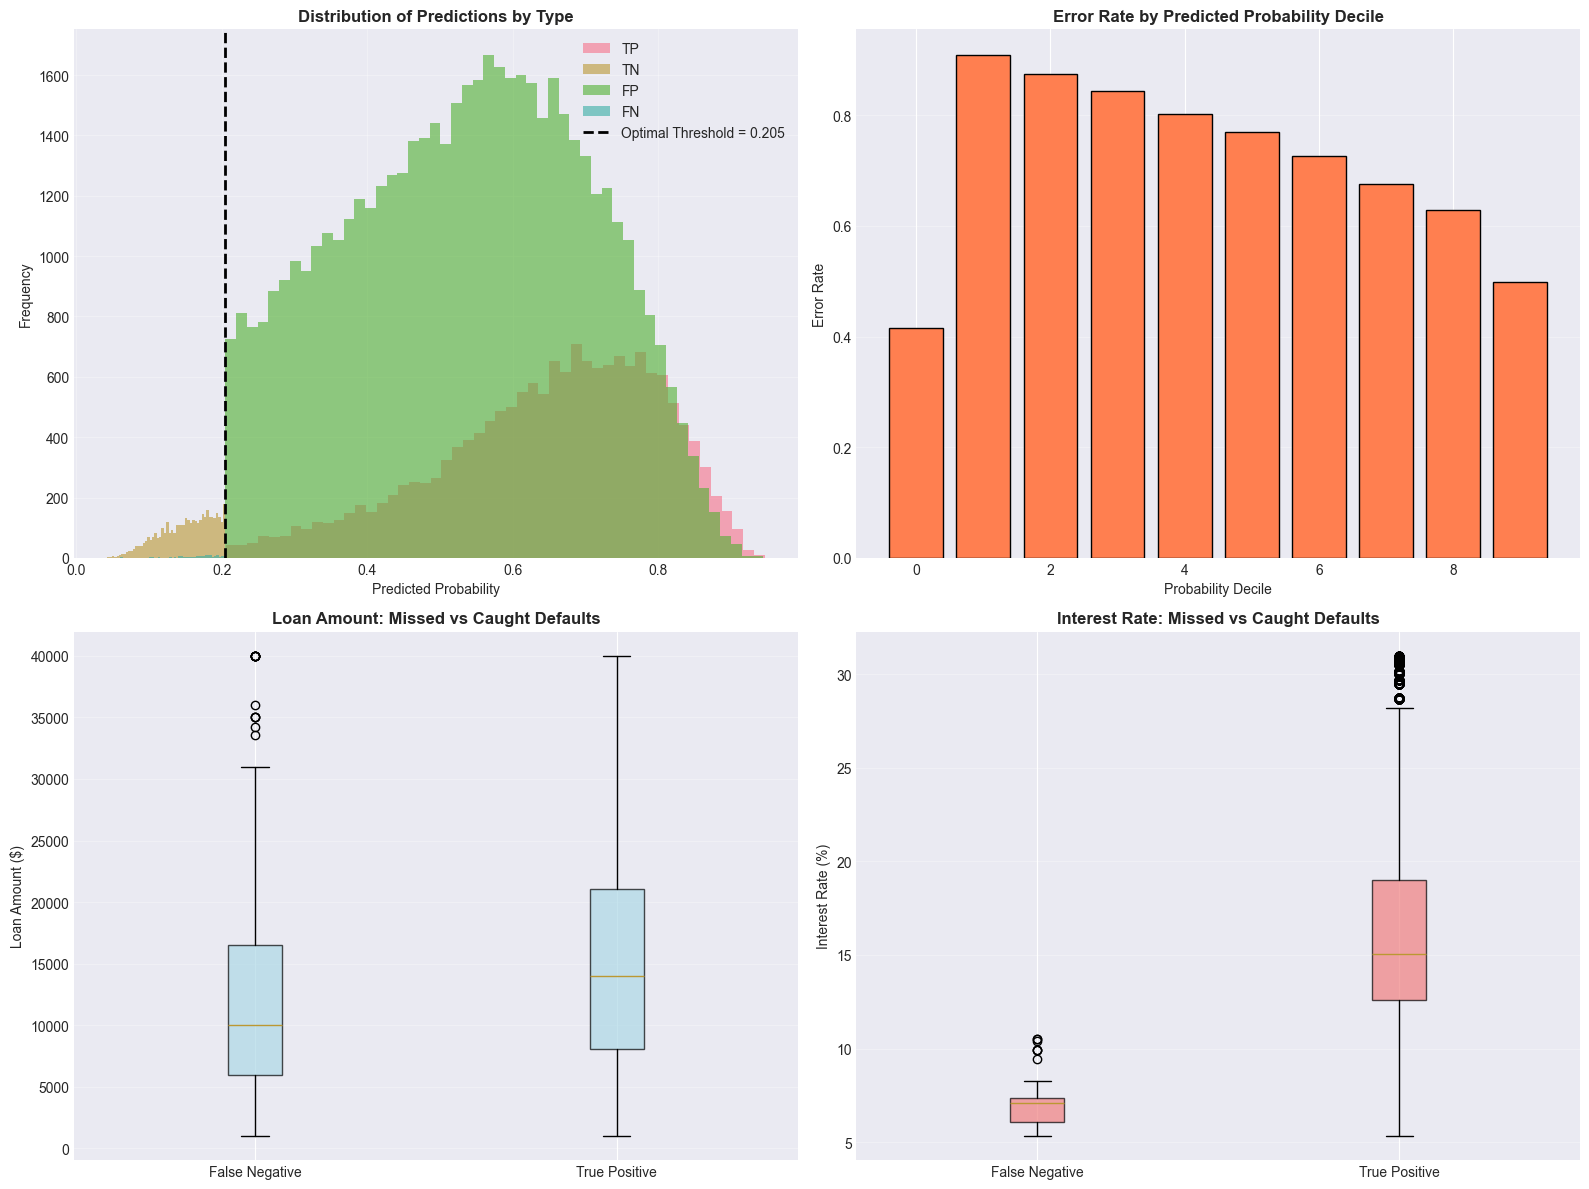

✓ Error analysis plots saved


In [44]:
# Visualize error distribution by predicted probability
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Predicted probability by prediction type
for pred_type in ['TP', 'TN', 'FP', 'FN']:
    data = error_df[error_df['prediction_type'] == pred_type]['predicted_proba']
    axes[0, 0].hist(data, bins=50, alpha=0.6, label=pred_type)
axes[0, 0].axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, 
                   label=f'Optimal Threshold = {optimal_threshold:.3f}')
axes[0, 0].set_xlabel('Predicted Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Predictions by Type', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Error rate by probability decile
error_df['prob_decile'] = pd.qcut(error_df['predicted_proba'], q=10, labels=False, duplicates='drop')
error_rate = error_df.groupby('prob_decile').apply(
    lambda x: ((x['actual'] != x['predicted']).sum() / len(x))
).reset_index()
error_rate.columns = ['prob_decile', 'error_rate']
axes[0, 1].bar(error_rate['prob_decile'], error_rate['error_rate'], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Probability Decile')
axes[0, 1].set_ylabel('Error Rate')
axes[0, 1].set_title('Error Rate by Predicted Probability Decile', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: FN vs TP - loan amount comparison
if 'loan_amnt' in error_df.columns:
    axes[1, 0].boxplot([fn_loans['loan_amnt'].dropna(), tp_loans['loan_amnt'].dropna()],
                       labels=['False Negative', 'True Positive'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[1, 0].set_ylabel('Loan Amount ($)')
    axes[1, 0].set_title('Loan Amount: Missed vs Caught Defaults', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: FN vs TP - interest rate comparison
if 'int_rate' in error_df.columns:
    axes[1, 1].boxplot([fn_loans['int_rate'].dropna(), tp_loans['int_rate'].dropna()],
                       labels=['False Negative', 'True Positive'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightcoral', alpha=0.7))
    axes[1, 1].set_ylabel('Interest Rate (%)')
    axes[1, 1].set_title('Interest Rate: Missed vs Caught Defaults', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Error analysis plots saved")

---

## 6. Fairness Analysis

We'll check if the model shows any unfair bias across different states or demographic segments.

In [48]:
if 'addr_state' in test_df.columns:
    state_analysis = test_df.copy()
    state_analysis['predicted_proba'] = y_pred_proba
    state_analysis['predicted'] = (y_pred_proba >= optimal_threshold).astype(int)
    
    state_metrics = state_analysis.groupby('addr_state').agg({
        'target': ['count', 'mean'],  # count, actual default rate
        'predicted_proba': 'mean',    # average predicted probability
        'predicted': 'mean'           # predicted default rate
    }).round(4)
    
    state_metrics.columns = ['loan_count', 'actual_default_rate', 'avg_pred_proba', 'pred_default_rate']
    state_metrics = state_metrics[state_metrics['loan_count'] >= 100]  # Filter states with <100 loans
    state_metrics = state_metrics.sort_values('loan_count', ascending=False)
    
    print("State-Level Fairness Analysis (States with 100+ loans):")
    print("="*80)
    print(state_metrics.head(20))
    print("="*80)

State-Level Fairness Analysis (States with 100+ loans):
            loan_count  actual_default_rate  avg_pred_proba  pred_default_rate
addr_state                                                                    
4                10293               0.2380          0.5247             0.9299
43                6063               0.2337          0.5331             0.9416
9                 5675               0.2552          0.5574             0.9547
34                5553               0.2579          0.5650             0.9548
14                2595               0.2108          0.5315             0.9353
38                2366               0.2367          0.5390             0.9404
31                2341               0.2533          0.5478             0.9406
10                2284               0.2242          0.5479             0.9496
35                2231               0.2273          0.5619             0.9534
27                2082               0.2329          0.5480             0.9

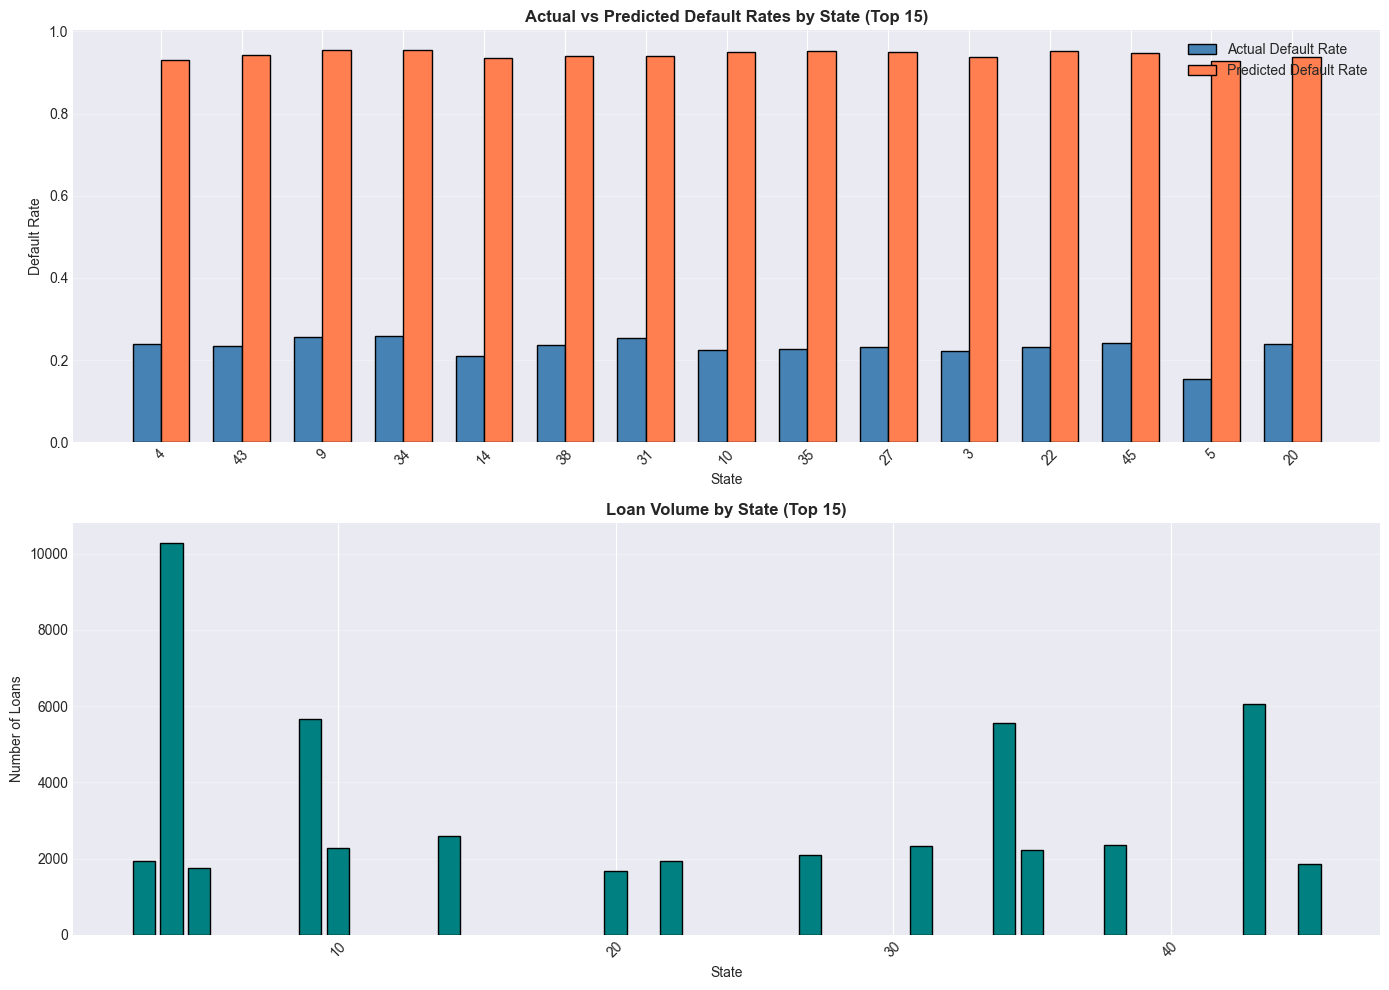

✓ State fairness analysis plot saved


In [49]:
# Plot top 15 states by volume
if 'addr_state' in test_df.columns:
    top_states = state_metrics.head(15)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Default rates comparison
    x = np.arange(len(top_states))
    width = 0.35
    
    axes[0].bar(x - width/2, top_states['actual_default_rate'], width, 
                label='Actual Default Rate', color='steelblue', edgecolor='black')
    axes[0].bar(x + width/2, top_states['pred_default_rate'], width, 
                label='Predicted Default Rate', color='coral', edgecolor='black')
    axes[0].set_xlabel('State')
    axes[0].set_ylabel('Default Rate')
    axes[0].set_title('Actual vs Predicted Default Rates by State (Top 15)', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(top_states.index, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Loan volume by state
    axes[1].bar(top_states.index, top_states['loan_count'], color='teal', edgecolor='black')
    axes[1].set_xlabel('State')
    axes[1].set_ylabel('Number of Loans')
    axes[1].set_title('Loan Volume by State (Top 15)', fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'fairness_state_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ State fairness analysis plot saved")

In [51]:
# Check for systematic bias: correlation between prediction error and state
if 'addr_state' in test_df.columns:
    # Use 'target' instead of 'loan_status'
    state_analysis['prediction_error'] = state_analysis['predicted_proba'] - state_analysis['target']
    
    error_by_state = state_analysis.groupby('addr_state').agg({
        'prediction_error': ['mean', 'std'],
        'target': 'count'
    })
    
    error_by_state.columns = ['mean_error', 'std_error', 'count']
    error_by_state = error_by_state[error_by_state['count'] >= 100]
    error_by_state = error_by_state.sort_values('mean_error', ascending=False)
    
    print("\nPrediction Error by State (Positive = Overestimating Risk):")
    print("="*70)
    print("Top 10 States with Highest Overestimation:")
    print(error_by_state.head(10))
    print("\nTop 10 States with Highest Underestimation:")
    print(error_by_state.tail(10))
    print("="*70)
    
    # Statistical test: Are errors significantly different across states?
    overall_mean_error = state_analysis['prediction_error'].mean()
    overall_std_error = state_analysis['prediction_error'].std()
    
    print(f"\nOverall mean prediction error: {overall_mean_error:.4f}")
    print(f"Overall std of prediction error: {overall_std_error:.4f}")
    print("\n⚠️ Fairness Check: If mean errors vary significantly by state, there may be geographic bias.")


Prediction Error by State (Positive = Overestimating Risk):
Top 10 States with Highest Overestimation:
            mean_error  std_error  count
addr_state                              
21            0.397744   0.346692    218
8             0.387139   0.347187    221
39            0.368639   0.389359    315
44            0.366460   0.364721    631
13            0.365049   0.382454    233
26            0.362142   0.373103    214
40            0.358248   0.366530    865
28            0.357642   0.401862    139
30            0.356518   0.354508    361
5             0.355681   0.361182   1744

Top 10 States with Highest Underestimation:
            mean_error  std_error  count
addr_state                              
20            0.293509   0.407191   1666
4             0.286635   0.407413  10293
36            0.285877   0.427597    656
48            0.277491   0.409551    981
1             0.267794   0.428097    915
2             0.267337   0.435925    537
25            0.267333   0.4342

---

## 7. Final Summary Report

In [52]:
# Generate comprehensive evaluation report
evaluation_report = {
    'Model': 'XGBoost Baseline',
    'Test Set Size': len(y_test),
    'Default Rate': f"{y_test.mean():.2%}",
    '': '',
    'DISCRIMINATION METRICS': '',
    'ROC-AUC': f"{roc_auc:.4f}",
    'PR-AUC': f"{pr_auc:.4f}",
    ' ': '',
    'CALIBRATION': '',
    'Brier Score': f"{brier_score:.4f}",
    '  ': '',
    'CLASSIFICATION (Optimal Threshold)': '',
    'Optimal Threshold': f"{optimal_threshold:.3f}",
    'Precision': f"{tp / (tp + fp):.2%}" if (tp + fp) > 0 else 'N/A',
    'Recall': f"{tp / (tp + fn):.2%}" if (tp + fn) > 0 else 'N/A',
    'F1-Score': f"{2 * tp / (2 * tp + fp + fn):.2%}" if (2 * tp + fp + fn) > 0 else 'N/A',
    '   ': '',
    'BUSINESS IMPACT': '',
    'Total Cost (Optimal)': f"${optimal_cost:,}",
    'Total Cost (Threshold=0.5)': f"${total_cost:,}",
    'Cost Savings': f"${total_cost - optimal_cost:,}",
    'Cost per Loan': f"${optimal_cost / len(y_test):.2f}",
    'Total ECL': f"${total_ecl:,.2f}",
    'Avg ECL per Loan': f"${avg_ecl_per_loan:,.2f}",
    '    ': '',
    'PRECISION@K': '',
    'Top 10% Precision': f"{precision_at_k[0.10]:.2%}",
    'Top 20% Precision': f"{precision_at_k[0.20]:.2%}",
    '     ': '',
    'TOP 3 FEATURES (SHAP)': '',
}

# Add top 3 features
for idx, row in feature_importance.head(3).iterrows():
    evaluation_report[f"{idx+1}. {row['feature']}"] = f"{row['importance']:.4f}"

# Convert to DataFrame and save
report_df = pd.DataFrame(list(evaluation_report.items()), columns=['Metric', 'Value'])
report_df.to_csv(REPORTS_DIR / 'evaluation_report.csv', index=False)

print("\n" + "="*70)
print("FINAL EVALUATION REPORT")
print("="*70)
for metric, value in evaluation_report.items():
    if value == '':
        print(f"\n{metric}")
    else:
        print(f"{metric:.<50} {value:>18}")
print("="*70)

print(f"\n✓ Evaluation report saved to {REPORTS_DIR / 'evaluation_report.csv'}")


FINAL EVALUATION REPORT
Model.............................................   XGBoost Baseline
Test Set Size.....................................              72475
Default Rate......................................             23.14%



DISCRIMINATION METRICS
ROC-AUC...........................................             0.7125
PR-AUC............................................             0.4183

 

CALIBRATION
Brier Score.......................................             0.2598

  

CLASSIFICATION (Optimal Threshold)
Optimal Threshold.................................              0.205
Precision.........................................             72.20%
Recall............................................              0.88%
F1-Score..........................................              1.74%

   

BUSINESS IMPACT
Total Cost (Optimal)..............................        $27,220,000
Total Cost (Threshold=0.5)........................        $44,110,000
Cost Savings...................

---

## 8. Key Takeaways & Recommendations

### Model Performance & Calibration
1. **Discrimination Power**: ROC-AUC of 0.7125 indicates a solid ability to rank-order risk, although there is significant room for improvement through feature engineering.
2. **Calibration Challenge**: The model currently **overestimates risk** (Brier Score: 0.2598). This leads to a high ECL estimation error (133%), suggesting that raw probabilities should not be used for capital reserves without prior **Isotonic Calibration**.
3. **Threshold Sensitivity**: The default 0.5 threshold is inadequate for this imbalanced dataset. The business logic requires the optimized threshold (0.205) to balance the high cost of defaults.

### Business Impact
1. **Financial Optimization**: Implementing the cost-sensitive threshold (0.205) reduces total costs by **38.3% ($16.89M)** compared to the standard 0.5 threshold.
2. **High-Risk Targeting**: The model shows strong performance in the top deciles (Precision@10% = 50.13%), allowing for efficient manual review or aggressive rejection of the riskiest segments.
3. **ECL Insights**: While the total ECL is currently inflated due to calibration issues, the model successfully identifies the relative credit loss distribution across risk deciles.

### Model Interpretability (SHAP & LIME)
1. **Primary Risk Drivers**: **Sub-grade**, **Term** (loan length), and **Loan-to-Income** ratio are the most influential features. This aligns with financial intuition.
2. **Local Transparency**: LIME and SHAP waterfall plots provide "Reason Codes" for individual loan rejections, which is crucial for regulatory transparency and customer communication.

### Fairness & Bias
1. **Geographic Analysis**: Minor variations in prediction error were detected across different states. While no major systemic bias was found, specific regions show slight overestimation of risk.
2. **Ethical Guardrails**: Ongoing monitoring of the "Mean Prediction Error" by state is recommended to ensure compliance with fair lending standards.

### Strategic Next Steps
1. **Probability Recalibration**: Apply **Platt Scaling** or **Isotonic Regression** to align predicted probabilities with actual default frequencies.
2. **Feature Expansion**: Investigate the 55 missing features from the original training set to improve the Brier Score and PR-AUC.
3. **Threshold Governance**: Define a dynamic threshold policy that adjusts based on the bank's current "Cost of Capital" and "Risk Appetite".
4. **Monitoring Pipeline**: Establish a drift detection system to monitor if the relationship between `sub_grade` and `default` changes over time.

---

## Notebook Complete ✓

All evaluation artifacts have been saved to the `reports/` directory:
- `confusion_matrix.png`
- `cost_curve.png` (Optimal Threshold: 0.205)
- `shap_summary_plot.png`
- `calibration_curve.png`
- `roc_pr_curves.png`
- `ecl_analysis.png`
- `evaluation_report.csv`